<a href="https://colab.research.google.com/github/joshuabae/Team-JPJ/blob/main/Josh's_Workspace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [3]:
# import lux
from fbprophet import Prophet

In [134]:
dog_train = pd.read_csv('https://raw.githubusercontent.com/joshuabae/Team-JPJ/main/filesForStartOfDatathon/training.csv')
# data_dict = files.upload()
# data_dict = pd.read_excel('data_dictionary.xlsx')
# score_format = pd.read_csv('https://raw.githubusercontent.com/joshuabae/Team-JPJ/main/filesForStartOfDatathon/scoring_format.csv')
# sub_format = pd.read_csv('https://raw.githubusercontent.com/joshuabae/Team-JPJ/main/filesForStartOfDatathon/submission_format.csv')

In [ ]:
final_scoring = files.upload('scoring.csv')
final_scoring = pd.read_excel('scoring.csv')

In [179]:
def generate_pred(csv_file):
  df = csv_file
  df = df.drop(columns=['Cash/Credit Site', 'Loyalty Site', 'ExtraMile Site',
                        'CoBrand', 'Food Service', 'City', 'State', 'GrossSoldQuantity'])
  
  df['DayOfTheWeek'] = df['dayOfTheYear'].map(lambda x: x % 7)

  df['EBT Site'] = df['EBT Site'].astype(int)
  df['Alcohol'] = df['Alcohol'].astype(int)
  df['Carwash'] = df['Carwash'].astype(int)

  df['predictions'] = reg.predict(df).astype(int)

  new_df = pd.concat([df['StoreNumber'], df['dayOfTheYear'], df['3HourBucket'],
                      df['predictions']], axis=1)
  
  new_df.rename(columns={"predictions": "GrossSoldQuantity"})

  return new_df

In [ ]:
new_df = generate_pred(final_scoring)

new_df.to_excel('submission.xlsx')
files.download('submission.xlsx')

In [180]:
new_df = generate_pred(score_format)

new_df.to_excel('submission.xlsx')
files.download('submission.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [132]:
new_df.columns, X_test.columns

(Index(['StoreNumber', 'dayOfTheYear', 'Weekday', 'Weekend', '3HourBucket_1',
        '3HourBucket_2', '3HourBucket_3', '3HourBucket_4', 'EBT Site_True',
        'Alcohol_True', 'Carwash_False', 'DayOfTheWeek_1', 'DayOfTheWeek_2',
        'DayOfTheWeek_3'],
       dtype='object'),
 Index(['StoreNumber', 'dayOfTheYear', 'Weekday', 'Weekend', '3HourBucket_1',
        '3HourBucket_2', '3HourBucket_3', '3HourBucket_4', 'EBT Site_False',
        'EBT Site_True', 'Alcohol_False', 'Alcohol_True', 'Carwash_False',
        'Carwash_True', 'DayOfTheWeek_0', 'DayOfTheWeek_1', 'DayOfTheWeek_2',
        'DayOfTheWeek_3', 'DayOfTheWeek_4', 'DayOfTheWeek_5', 'DayOfTheWeek_6'],
       dtype='object'))

In [135]:
# clean data and rid outliers
train = dog_train.drop(columns=['Cash/Credit Site', 'Loyalty Site',
                                'ExtraMile Site','CoBrand', 'Food Service', 'City', 'State'])

# drop july 4th data
index = train[train['dayOfTheYear'] == 185].index
train = train.drop(index=index).reset_index(drop=True)

train['DayOfTheWeek'] = train['dayOfTheYear'].map(lambda x: x % 7)

In [136]:
# train['Weekday'] = train['DayOfTheWeek'].map(lambda x: 1 if x in [2,3,4] else 0)
# train['Weekend'] = train['DayOfTheWeek'].map(lambda x: 1 if x in [1,5,6,7] else 0)

In [138]:
y = train['GrossSoldQuantity']

X = train.drop(columns=['GrossSoldQuantity'])

X['EBT Site'] = X['EBT Site'].astype(int)
X['Alcohol'] = X['Alcohol'].astype(int)
X['Carwash'] = X['Carwash'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42, stratify=X['StoreNumber'])

In [140]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

xgb = XGBRegressor()

parameters = {'objective': ['reg:squarederror'],
              'eval_metric': ['rmse'],
              'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'min_child_weight': [2, 3, 4],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'n_estimators': [100, 200, 400, 600, 800, 1000, 1200]}

xgb_model = RandomizedSearchCV(xgb,
                               parameters,
                               cv = 5,
                               n_jobs = -1,
                               verbose=True)

xgb_model.fit(X_train, y_train)


In [181]:
# make predictions
y_pred = pd.Series(xgb_model.predict(X_test))
print("RMSE: " + str(mean_squared_error(y_pred, y_test, squared=False)))

RMSE: 10.300710473983061


In [ ]:
# 104 MSE
results = pd.concat([y_test, y_pred], axis=1)
results.head(20)
# type(y_test)

In [ ]:
from lightgbm import LGBMRegressor

light_gbm = LGBMRegressor()

# Parameters for tuning
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'n_estimators': [100, 200, 400, 600, 800, 1000, 1200]}

gbr = RandomizedSearchCV(light_gbm,
                         param_distributions=parameters,
                         cv=5,
                         n_jobs=-1,
                         scoring='neg_root_mean_squared_error',
                         verbose=True)

# Gradient Boosting Regressor
gbr.fit(X_train, y_train)

In [188]:
# make predictions
y_pred = pd.Series(gbr.predict(X_test))
print("RMSE: " + str(mean_squared_error(y_pred, y_test, squared=True)))

RMSE: 98.40022813431672


In [ ]:
"# 104 MSE
results = pd.concat([y_test, y_pred], axis=1)
results.head(20)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

# grid search param tuning
parameters = {'n_estimators':[100, 200, 300, 400, 500, 600], 
              'criterion':['mse'], 
              'max_depth':[8, 9, 10],
              'max_features': [5, 6, 7, 8]}

rf_model = GridSearchCV(rf, parameters,
                         cv=5,
                         n_jobs=-1,
                         scoring='neg_root_mean_squared_error',
                         verbose=True)

# rf_model = GridSearchCV(rf, parameters, cv=5, scoring='neg_mean_absolute_error', verbose=True)
rf_model.fit(X_train, y_train)

In [196]:
# rf_model.best_params_, gbr.best_params_, xgb_model.best_params_

In [187]:
# make predictions
y_pred = pd.Series(rf_model.predict(X_test))
print("RMSE: " + str(mean_squared_error(y_pred, y_test, squared=False)))

RMSE: 9.976157218381491


In [ ]:
from sklearn.ensemble import StackingRegressor

estimators = [('rf', rf_model),
              ('lgb', light_gbm),
              ('xgb', xgb_model)]

reg = StackingRegressor(estimators=estimators,
                        final_estimator=RandomForestRegressor(n_estimators=10, random_state=42))

In [ ]:
reg.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.7min finished


[20:04:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.0min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.0min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.0min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.7min


In [200]:
# make predictions
y_pred = pd.Series(reg.predict(X_test))
print("RMSE: " + str(mean_squared_error(y_pred, y_test, squared=False)))

RMSE: 11.193642618704953


In [ ]:
# Get final precitions from the blended model
for i in range(0, 110, 10):
  j = 100 - i
  blended_score = mean_squared_error(y_train, blended_predictions(X_train, i/100, j/100), squared=False)
  print('MSE score on train data:')
  print(blended_score)

### Below is work on data viz

In [ ]:
bucket_1 = train.loc[train['3HourBucket'] == 1].reset_index(drop=True)
bucket_2 = train.loc[train['3HourBucket'] == 2].reset_index(drop=True)
bucket_3 = train.loc[train['3HourBucket'] == 3].reset_index(drop=True)
bucket_4 = train.loc[train['3HourBucket'] == 4].reset_index(drop=True)

bucket_lst = [bucket_1, bucket_2, bucket_3, bucket_4]

In [ ]:
day_translator = {0: "Wed",1: "Thu",2: "Fri",3: "Sat",4: "Sun",5: "Mon",6: "Tue"}

# (store_df_dict["dayOfTheYear"] % 7) == dayOfTheWeek

standard_keys = ["Wed", "Thu", "Fri", "Sat", "Sun", "Mon", "Tue"]
bucket_dct = {key:[] for key in standard_keys}

for bucket in bucket_lst:
  bucket_dct["Wed"].append(bucket.loc[train['dayOfTheYear'] % 7 == 0])
  bucket_dct["Thu"].append(bucket.loc[train['dayOfTheYear'] % 7 == 1])
  bucket_dct["Fri"].append(bucket.loc[train['dayOfTheYear'] % 7 == 2])
  bucket_dct["Sat"].append(bucket.loc[train['dayOfTheYear'] % 7 == 3])
  bucket_dct["Sun"].append(bucket.loc[train['dayOfTheYear'] % 7 == 4])
  bucket_dct["Mon"].append(bucket.loc[train['dayOfTheYear'] % 7 == 5])
  bucket_dct["Tue"].append(bucket.loc[train['dayOfTheYear'] % 7 == 6])

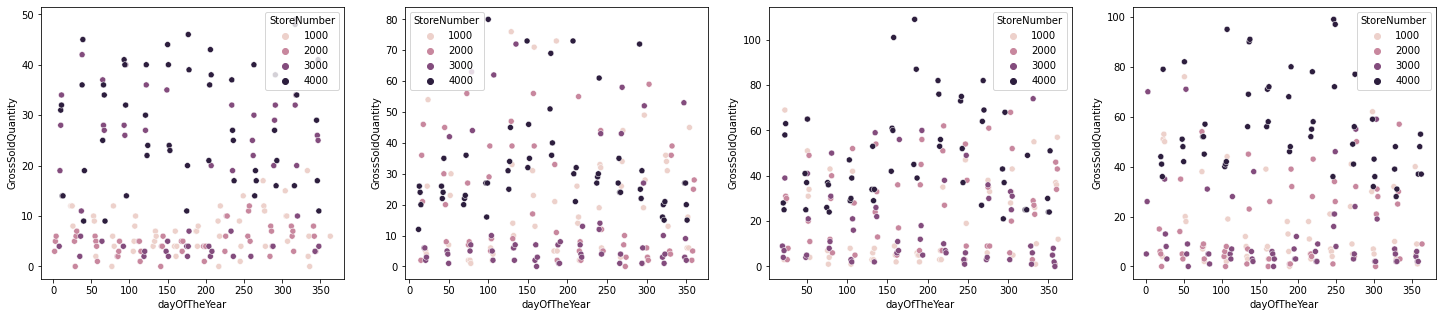

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(25, 5))
for i in range(4):
  data = bucket_dct["Tue"][i]
  sns.scatterplot(data=data, y='GrossSoldQuantity', x='dayOfTheYear', hue='StoreNumber', ax=ax[i])

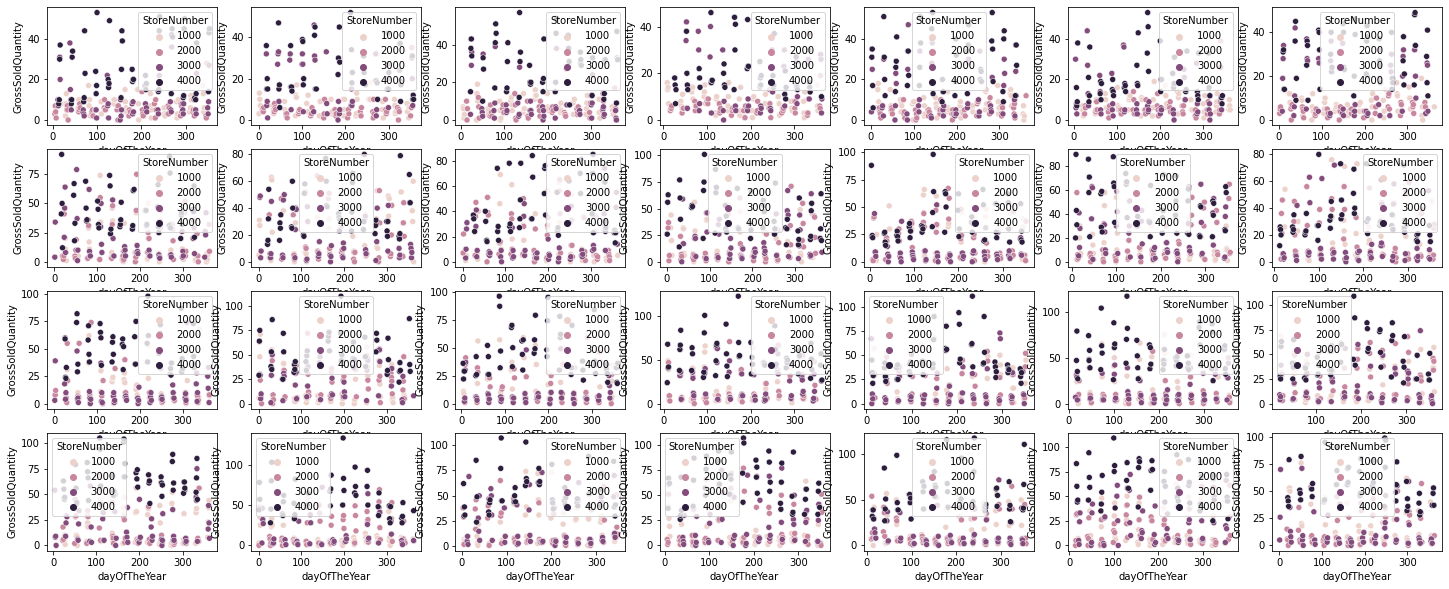

In [ ]:
fig, ax = plt.subplots(4,7,figsize=(25, 10))

j = 0
i = 0
for key in bucket_dct.keys():
  j = 0
  for df in bucket_dct[key]:
    data = df
    sns.lineplot(data=data, y='GrossSoldQuantity', x='dayOfTheYear', hue='StoreNumber', ax=ax[j, i])
    j += 1
  i += 1

In [ ]:
store_1 = train.loc[train['StoreNumber'] == 1000].reset_index(drop=True)
store_2 = train.loc[train['StoreNumber'] == 2000].reset_index(drop=True)
store_3 = train.loc[train['StoreNumber'] == 3000].reset_index(drop=True)
store_4 = train.loc[train['StoreNumber'] == 4000].reset_index(drop=True)

In [ ]:
store_lst = [store_1, store_2, store_3, store_4]
df_lst = []
for store in store_lst:
  values = store.groupby(['dayOfTheYear'])['GrossSoldQuantity'].mean().reset_index(drop=True)
  day = pd.Series(store['dayOfTheYear'].map(lambda x: datetime.date.fromordinal(x)).unique()).map(lambda x: x.replace(year=2020))
  df = pd.concat([day, values], axis=1)
  df.columns = ['ds', 'y']
  df_lst.append(df)

In [ ]:
fore_lst = []
# holidays = create_end_of_year_holydays_df()
for df in df_lst: 
  m = Prophet(yearly_seasonality=False, weekly_seasonality=True,
              daily_seasonality=False)
  m.fit(df)

  future = m.make_future_dataframe(periods=2)
  # future.tail()

  forecast = m.predict(future)
  # forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
  m.plot(forecast)
  fore_lst.append(forecast)

In [ ]:
# for forecast in fore_lst:
#   print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

In [ ]:
import datetime

values = train.groupby(['dayOfTheYear'])['GrossSoldQuantity'].mean().reset_index(drop=True)
day = pd.Series(train['dayOfTheYear'].map(lambda x: datetime.date.fromordinal(x)).unique())
day = day.map(lambda x: x.replace(year=2020))
df = pd.concat([day, values], axis=1)
df.columns = ['ds', 'y']

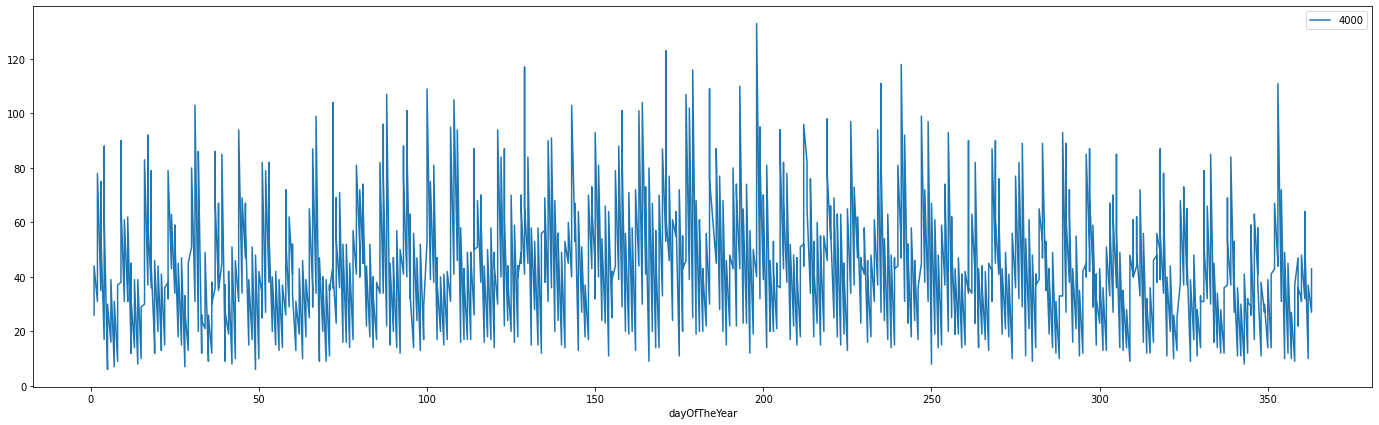

In [ ]:
dog_train = pd.read_csv('https://raw.githubusercontent.com/joshuabae/Team-JPJ/main/filesForStartOfDatathon/training.csv')

fig, ax = plt.subplots(figsize=(24,7))

# train['GrossSoldQuantity'] = train.groupby('StoreNumber')['GrossSoldQuantity'].transform(lambda x: (x - x.mean()) / x.std())

train.set_index('dayOfTheYear', inplace=True)
train.groupby('StoreNumber')['GrossSoldQuantity'].plot(ax=ax, legend=True);

# no_red = train.loc[train['StoreNumber'] == 4000]
# no_red.groupby('StoreNumber')['GrossSoldQuantity'].plot(ax=ax, legend=True);